In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from g2p_en import G2p
import re

from basicOperations.manifoldOperations import matrixDistance, frechetMean
import torch.nn.utils as utils

from rnn import euclideanRnn
import math

import pickle
import Levenshtein
import os

import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
"""
Proof for table 1, figure 2, and figure 3.
"""

In [ ]:
"""
Train LARGE-VOCAB EMG-to-phoneme conversion.

For description of the data, please see largeVocabDataVisualization.ipynb

Unlike data SMALL-VOCAB, there are no timestamps between words within a sentence. 

Given a sentence, you decode it fully using CTC loss. The pipeline resembles standard speech-to-text (ASR) techniques.

This is a baseline method that uses spectrograms insted of SPD matrices.
"""

"""https://pypi.org/project/Levenshtein/ - install this Lev distance."""

In [2]:
"""
Open Data.
"""

with open("DATA/dataLargeVocab.pkl", "rb") as file:
    DATA = pickle.load(file)

with open("DATA/labelsLargeVocab.pkl", "rb") as file:
    LABELS = pickle.load(file)

In [3]:
"""
English phoneme definitions.
"""
tok2id = {}
with open("DATA/ckptsLargeVocab/lang_phone/tokens.txt") as f:
    for line in f:
        s, i = line.strip().split()
        i = int(i)
        if s == "<eps>" or s.startswith("#"):
            continue
        tok2id[s] = i
PHONE_DEF = tok2id


def phoneToId(p):
    return PHONE_DEF[p]

g2p = G2p()

In [4]:
"""
Phonemize the sentences.
"""

phonemizedSentences = []

for i in range(len(LABELS)):
    phones = []
    for p in g2p(LABELS[i]): 
        p = re.sub(r'[0-9]', '', p)   
        if re.match(r'[A-Z]+', p): 
            phones.append(p)
    phonemizedSentences.append(phones)

In [5]:
"""
Convert phone-to-indices using look-up dictionary PHONE_DEF.
"""

phoneIndexedSentences = []
for i in range(len(phonemizedSentences)):
    current = phonemizedSentences[i]
    phoneID = []
    for j in range(len(current)):
        phoneID.append(phoneToId(current[j]))
    phoneIndexedSentences.append(phoneID)

In [6]:
def tokenIdToClassIdx(tokenId: int) -> int:
    return tokenId - 1   

def phoneSeqToClassIdxSeq(phoneSeq):
    return [tokenIdToClassIdx(PHONE_DEF[p]) for p in phoneSeq]

classIndexedSentences = [phoneSeqToClassIdxSeq(seq) for seq in phonemizedSentences]

In [7]:
"""
Pad the phone transcribed sentences to a common length (to be used with CTC loss).
"""

phonemizedLabels = np.zeros((len(classIndexedSentences), 76)) - 1
for i in range(len(classIndexedSentences)):
    phonemizedLabels[i, 0:len(classIndexedSentences[i])] = classIndexedSentences[i]

labelLengths = np.zeros((len(classIndexedSentences)))
for i in range(len(classIndexedSentences)):
    labelLengths[i] = len(classIndexedSentences[i])

In [8]:
"""
z-normalize the data along the time dimension.
"""

normDATA = []
for i in range(len(DATA)):
    Mean = np.mean(DATA[i], axis = -1)
    Std = np.std(DATA[i], axis = -1)
    normDATA.append((DATA[i] - Mean[..., np.newaxis])/Std[..., np.newaxis])

In [9]:
"""Create EMG spectrograms. Bin the frequencies into 31 bins (so that the neural network size remains consistent with that 
of SPD matrices for fair comparison)."""

def spectrogramEmg(
    X: np.ndarray,                 
    fs: int = 5000,
    winMs: float = 50.0,
    hopMs: float = 20.0,
    targetBins: int = 31,        
) -> np.ndarray:
   
    Xnp = np.asarray(X, dtype = np.float32)
    if Xnp.ndim == 2:
        Xnp = Xnp[None, ...]     
    N, C, T = Xnp.shape
    assert C == 31, f"Expected 31 channels, got {C}"

    winLength = int(round(fs * winMs / 1000.0))   
    hopLength = int(round(fs * hopMs / 1000.0))  
    assert winLength == 250, f"win_length computed {winLength}, expected 250 with fs={fs}"
    assert hopLength == 100, f"hop_length computed {hopLength}, expected 100 with fs={fs}"

    nFft = 256        

    x = torch.from_numpy(Xnp)          
    window = torch.hann_window(winLength, dtype = x.dtype, device = x.device)

          
    x2 = x.reshape(N * C, T) 

    S = torch.stft(
        x2, n_fft = nFft, hop_length = hopLength, win_length = winLength,
        window = window, center = False, return_complex = True
    )                                        
    mags = S.abs()
    power = mags.pow(2) 

    pooled = F.adaptive_avg_pool1d(power.transpose(1, 2), output_size = targetBins)
    pooled = pooled.transpose(1, 2)
    pooled = pooled * (power.shape[1] / float(targetBins))
    pooled = pooled.clamp_min(1e-12)
    db = 10 * torch.log10(pooled)
    frames = db.shape[-1]
    out = db.reshape(N, C, targetBins, frames).permute(3, 0, 1, 2).contiguous()
    return out.cpu().numpy().astype(np.float32).squeeze()

In [10]:
specMatrices = []
for i in range(len(normDATA)):
    specMatrices.append(spectrogramEmg(normDATA[i]))

In [11]:
print(len(specMatrices))
print(specMatrices[0].shape)

10970
(186, 31, 31)


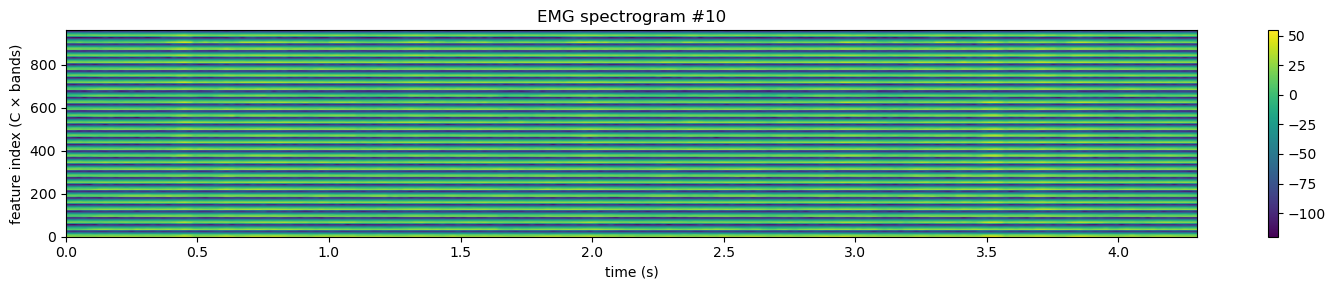

In [31]:
def plotEmgSpectrum(sample, hopSeconds, title = None, ax = None):
    
    T = sample.shape[0]
    if ax is None:
        fig, ax = plt.subplots(figsize = (15, 3))
    im = ax.imshow(sample.T, aspect = 'auto', origin = 'lower',
                   extent = [0, T*hopSeconds, 0, sample.shape[1]])
    ax.set_xlabel('time (s)')
    ax.set_ylabel('feature index (C × bands)')
    if title: ax.set_title(title)
    plt.colorbar(im, ax = ax)
    plt.tight_layout()
    return ax

idx = 10
hopLength = int(round(5000 * 20.0 / 1000.0))  
hopSeconds = hopLength / 5000.0    
A = specMatrices[idx].reshape(specMatrices[idx].shape[0], -1)
plotEmgSpectrum(A, hopSeconds, title = f"EMG spectrogram #{idx}")
plt.show()

In [15]:
afterMatrices = np.zeros((len(specMatrices), 409, 31, 31)) 
inputLengths = np.zeros((len(specMatrices)))
for i in range(len(specMatrices)):
    for j in range(len(specMatrices[i])):
        temp = specMatrices[i][j]
        afterMatrices[i, j] = temp
    inputLengths[i] = len(specMatrices[i])

In [16]:
class BaseDataset(Dataset):
    def __init__(self, data, labels, inputLength, targetLength):
        self.data = data 
        self.labels = labels
        self.targetLength = targetLength
        self.inputLength = inputLength

    def __getitem__(self, index):
        inputSeq = self.data[index].astype('float32')  
        targetSeq = self.labels[index]
        inputLength = int(self.inputLength[index])
        targetLength = int(self.targetLength[index])
        return inputSeq, targetSeq, inputLength, targetLength

    def __len__(self):
        return len(self.data)

In [17]:
"""
Train-validation-test split.
"""

trainFeatures = afterMatrices[:8000]
trainLabels = phonemizedLabels[:8000]
trainLabelLengths = labelLengths[:8000]
trainInputLengths = inputLengths[:8000]

valFeatures = afterMatrices[8000:9000]
valLabels = phonemizedLabels[8000:9000]
valLabelLengths = labelLengths[8000:9000]
valInputLengths = inputLengths[8000:9000]

testFeatures = afterMatrices[9000:]
testLabels = phonemizedLabels[9000:]
testLabelLengths = labelLengths[9000:]
testInputLengths = inputLengths[9000:]

In [18]:
trainDataset = BaseDataset(trainFeatures, trainLabels, trainInputLengths, trainLabelLengths)
valDataset = BaseDataset(valFeatures, valLabels, valInputLengths, valLabelLengths)
testDataset = BaseDataset(testFeatures, testLabels, testInputLengths, testLabelLengths)

trainDataloader = DataLoader(trainDataset, batch_size = 32, shuffle = True)
valDataloader = DataLoader(valDataset, batch_size = 32, shuffle = False)
testDataloader = DataLoader(testDataset, batch_size = 1, shuffle = False)

In [19]:
def trainOperation(model,  device, trainLoader, rnnOptimizer, Loss):
    model.train()
    totalLoss = 0
    for inputs, targets, inputLengths, targetLengths in trainLoader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputLengths, targetLengths = inputLengths.to(device), targetLengths.to(device)
        
        rnnOptimizer.zero_grad()

        outputs = model(inputs, inputLengths.cpu())
        loss = Loss(outputs, targets, inputLengths, targetLengths)
        loss.backward()
        rnnOptimizer.step()

        totalLoss += loss.item()
        
    
    return totalLoss / len(trainLoader)


def valOperation(model, device, valLoader, Loss):
    model.eval()
    totalLoss = 0
    with torch.no_grad():
        for inputs, targets, inputLengths, targetLengths in valLoader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputLengths, targetLengths = inputLengths.to(device), targetLengths.to(device)
            
            outputs = model(inputs, inputLengths.cpu()) 
            loss = Loss(outputs, targets, inputLengths, targetLengths)
            totalLoss += loss.item()

    return totalLoss / len(valLoader)

In [67]:
"""
To replicate the PER (phoneme error rate) for various model sizes and layers, change the variable here:
euclideanRnn.RnnNet(41, modelHiddenDimension = 25, device, numLayers = 3).to(device)
"""

dev = "cuda:0"
device = torch.device(dev)

numberEpochs = 100

model = euclideanRnn.RnnNet(41, 25, device, numLayers = 3).to(device)
numParams = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(numParams)
lossFunction = nn.CTCLoss(blank = 40, zero_infinity = True)
rnnOptimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 1e-3)

6348591


In [23]:
"""
Do training.
"""
valLOSS = []
minLOSS = 100
for epoch in range(numberEpochs):
    trainLoss = trainOperation(model, device, trainDataloader, rnnOptimizer, lossFunction)
    valLoss = valOperation(model, device, valDataloader, lossFunction)
    valLOSS.append(valLoss)
    if minLOSS > valLoss:
        minLOSS = valLoss
        torch.save(model.state_dict(), "ckpts/emgSpectra/0.pt")
    print(f'Epoch: {epoch + 1}/{numberEpochs}, Training loss: {trainLoss:.4f}, Val loss: {valLoss:.4f}')
np.save("ckpts/emgSpectra/valLoss.npy", valLOSS)

Epoch: 1/100, Training loss: 3.6116, Val loss: 3.5179
Epoch: 2/100, Training loss: 3.5195, Val loss: 3.5076
Epoch: 3/100, Training loss: 3.5147, Val loss: 3.5273
Epoch: 4/100, Training loss: 3.5073, Val loss: 3.5069
Epoch: 5/100, Training loss: 3.5043, Val loss: 3.4984
Epoch: 6/100, Training loss: 3.4994, Val loss: 3.5027
Epoch: 7/100, Training loss: 3.4975, Val loss: 3.5015
Epoch: 8/100, Training loss: 3.4950, Val loss: 3.4916
Epoch: 9/100, Training loss: 3.4913, Val loss: 3.4819
Epoch: 10/100, Training loss: 3.4894, Val loss: 3.4662
Epoch: 11/100, Training loss: 3.4849, Val loss: 3.4905
Epoch: 12/100, Training loss: 3.4844, Val loss: 3.4817
Epoch: 13/100, Training loss: 3.4830, Val loss: 3.4777
Epoch: 14/100, Training loss: 3.4821, Val loss: 3.4760
Epoch: 15/100, Training loss: 3.4782, Val loss: 3.4616
Epoch: 16/100, Training loss: 3.4810, Val loss: 3.4695
Epoch: 17/100, Training loss: 3.4796, Val loss: 3.4751
Epoch: 18/100, Training loss: 3.4781, Val loss: 3.4625
Epoch: 19/100, Trai

In [24]:
np.save("ckpts/emgSpectra/valLoss.npy", valLOSS)

In [25]:
valLoss = np.load("ckpts/emgSpectra/valLoss.npy")
print(np.min(valLoss))
print(np.argmin(valLoss))
epoch = np.argmin(valLoss)

3.3661384508013725
74


In [68]:
def testOperation(model, device, testLoader, Loss):
    model.eval()
    totalLoss = 0
    Outputs = []
    with torch.no_grad():
        for inputs, targets, inputLengths, targetLengths in testLoader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputLengths, targetLengths = inputLengths.to(device), targetLengths.to(device)
            
            outputs = model(inputs, inputLengths.cpu()) 

            loss = Loss(outputs, targets, inputLengths, targetLengths)
            totalLoss += loss.item()
            Outputs.append(outputs.transpose(0, 1))

    return Outputs, totalLoss / len(testLoader)

In [27]:
"""
Simple beam-search algorithm.
"""

def ctcPrefixBeamSearch(
    logProbs,
    testLen = None,
    beamSize = 5,
    blank = 40,
    topk = None,
    allowDoubles = True,
):
    
    lp = np.asarray(logProbs)
    Ttotal, V = lp.shape
    T = Ttotal if testLen is None else int(min(testLen, Ttotal))

    beams = {(): (0.0, -np.inf)}

    def add(store, seq, addPb, addPnb):
        if seq in store:
            pb, pnb = store[seq]
            if addPb  != -np.inf: pb  = np.logaddexp(pb,  addPb)
            if addPnb != -np.inf: pnb = np.logaddexp(pnb, addPnb)
            store[seq] = (pb, pnb)
        else:
            store[seq] = (addPb, addPnb)

    for t in range(T):
        row = lp[t] 
        new = {}

        if topk is not None and topk < V:
            cand = np.argpartition(row, -topk)[-topk:]
            if blank not in cand:
                worstIdx = cand[np.argmin(row[cand])]
                cand[cand == worstIdx] = blank
        else:
            cand = range(V)

        for seq, (pb, pnb) in beams.items():
            add(new, seq, np.logaddexp(pb, pnb) + row[blank], -np.inf)

            last = seq[-1] if seq else None

            for c in cand:
                if c == blank:
                    continue
                pC = row[c]

                if c == last:
            
                    add(new, seq, -np.inf, pnb + pC)

                    if allowDoubles:
                        add(new, seq + (c,), -np.inf, pb + pC)
                else:
                    add(new, seq + (c,), -np.inf, np.logaddexp(pb, pnb) + pC)

        if len(new) > beamSize:
            items = sorted(new.items(),
                           key = lambda kv: np.logaddexp(*kv[1]),
                           reverse = True)[:beamSize]
            beams = dict(items)
        else:
            beams = new

    bestSeq = max(beams.items(), key = lambda kv: np.logaddexp(*kv[1]))[0]
    return bestSeq

def findClosestTranscription(decodedTranscript, phoneticTranscription):
    
    dist = Levenshtein.distance(decodedTranscript, phoneticTranscription)

    return dist

In [69]:
modelWeight = torch.load("DATA/ckptsLargeVocab/emgSpectra.pt", weights_only = True)
model.load_state_dict(modelWeight)
output, testLoss = testOperation(model, device, testDataloader, lossFunction)

print("TEST LOSS: ", testLoss)

TEST LOSS:  3.3691992530967982


In [37]:
outs = []
for o in output:
    for oo in o:
        outs.append(oo)

In [38]:
print(len(outs))
print(outs[0].shape)

1970
torch.Size([147, 41])


In [39]:
PHONE_DEF1 = {}
for k, v in PHONE_DEF.items():
    PHONE_DEF1[v - 1] = k

In [40]:
LEVS = []
decodedOut = []
for i in range(1970):
    print(i)
    decodedSymbols = ctcPrefixBeamSearch(outs[i].cpu().numpy(), testInputLengths[i], beamSize = 50) 
    phoneOut = []
    for j in range(len(decodedSymbols)):
        phoneOut.append(PHONE_DEF1[decodedSymbols[j]])
    decodedOut.append(phoneOut)

levs = []
phoneLENGTHS = []
for i in range(len(decodedOut)):
    phoneLENGTHS.append(len(phonemizedSentences[9000 + i]))
    levs.append(findClosestTranscription(decodedOut[i], phonemizedSentences[9000 + i]))
LEVS.append(np.mean(levs))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [41]:
print("Mean length of sentences: ", np.mean(phoneLENGTHS))
print("Mean phoneme errors (insertion errors + deletion errors + substitution errors): ", np.mean(levs))
print("Percent phoneme error: ", np.sum(levs)/np.sum(phoneLENGTHS))

Mean length of sentences:  19.590862944162435
Mean phoneme errors (insertion errors + deletion errors + substitution errors):  17.485786802030457
Percent phoneme error:  0.8925480644659791


In [42]:
"""
Sort the decoded sentences from best-to-worst. Display 100 best decoded sentences.
"""

indices = np.argsort(np.array(levs)/np.array(phoneLENGTHS))
print(indices[:100])

[ 444 1701 1279  825 1477 1329 1966 1336  731 1879 1756  798  734 1704
  150 1326  201  522  595  700 1925 1185  645  572 1513 1507 1497 1717
  952  623  782 1786 1097  497 1803  250  532  953 1476 1597  353 1313
 1038  750  419 1911  620  810  559 1464 1398  673 1706  316  340  710
  343  684 1314 1689 1295 1931   23 1051 1745 1251 1922 1693  755 1901
  611 1343  489  962  923 1532  622 1924  305  976 1394  941 1169 1576
  511  881   41  339 1817  452  852 1467 1035  191  667 1268  658  173
  179  420]


In [48]:
for i in range(len(decodedOut)):
    print(decodedOut[i])

['AH', 'T', 'T', 'T', 'T', 'T']
['AH', 'T', 'T', 'T']
['AH', 'T', 'T', 'T', 'T']
['AH', 'T', 'T', 'T', 'T', 'T', 'AH', 'T']
['AH', 'T', 'T', 'T']
['AH', 'T', 'T', 'T']
['AH', 'T', 'T', 'T', 'T', 'T']
['AH', 'T', 'T', 'T', 'T']
['AH', 'T', 'T', 'T', 'T']
['AH', 'T', 'T', 'T']
['AH', 'T', 'T', 'T', 'T', 'T']
['AH', 'T', 'T', 'T']
['AH', 'T', 'T']
['AH', 'T', 'T', 'T', 'T', 'T']
['AH', 'T', 'T', 'T', 'T', 'T']
['AH', 'T', 'T', 'T']
['AH', 'T', 'T']
['AH', 'T', 'T', 'T', 'T']
['AH', 'T', 'T', 'T', 'T', 'T', 'T']
['AH', 'T', 'T', 'T', 'T', 'T', 'T']
['AH', 'T', 'T', 'T', 'T', 'T']
['AH', 'T', 'T', 'T', 'T']
['AH', 'T', 'T', 'T']
['AH', 'T', 'T']
['AH', 'T', 'T', 'T']
['AH', 'T', 'T', 'T', 'T', 'T']
['AH', 'T', 'T', 'T', 'T', 'T']
['AH', 'T', 'T', 'T', 'T', 'T']
['AH', 'T', 'T', 'T', 'T']
['AH', 'T', 'T', 'T', 'T']
['AH', 'T', 'T', 'T', 'T', 'T']
['AH', 'T', 'T', 'T', 'T']
['AH', 'T', 'T']
['AH', 'T', 'T', 'T', 'T']
['AH', 'T', 'T', 'T', 'T', 'T']
['AH', 'T', 'T', 'T', 'T', 'T']
['AH', 'T', 

In [47]:
"""
Visualize decoded sentences.
"""

which = 522
print("Decoded phoneme sequence: ", decodedOut[which])
print("Ground truth phoneme sequence: ", phonemizedSentences[9000 + which])
print("Ground truth label: ", LABELS[9000 + which])
print(" ")
print("Levenshtein distance between decoded and ground truth sequence: ", Levenshtein.distance(decodedOut[which], phonemizedSentences[9000 + which]))
print("Length of ground truth sequence: ", len(phonemizedSentences[9000 + which]))

Decoded phoneme sequence:  ['AH', 'T', 'T']
Ground truth phoneme sequence:  ['DH', 'AE', 'T', 'W', 'AA', 'Z', 'AH', 'B', 'AW', 'T', 'IH', 'T']
Ground truth label:  that was about it
 
Levenshtein distance between decoded and ground truth sequence:  9
Length of ground truth sequence:  12


In [49]:
np.save("spectogram.npy", np.array(levs)/np.array(phoneLENGTHS))

In [50]:
import torch, k2
from pathlib import Path
import sys

ICEFALL_ROOT = Path("/mnt/dataDrive/emgFullCorpora/toUpload/Icefall/").resolve()
if str(ICEFALL_ROOT) not in sys.path:
    sys.path.insert(0, str(ICEFALL_ROOT))


from icefall.lexicon import Lexicon
from icefall.decode import get_lattice, one_best_decoding
from icefall.utils import get_texts

In [52]:
langDir = "DATA/ckptsLargeVocab/lang_phone"
device = "cpu"  


def readSymbolTable(path):
    s2i, i2s, maxId = {}, {}, -1
    with open(path, "r", encoding = "utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            s, i = line.split()
            i = int(i)
            s2i[s] = i
            i2s[i] = s
            if i > maxId:
                maxId = i
    return s2i, i2s, maxId + 1 

def safeLoadFsaDict(ptPath):
    try:
        d = torch.load(ptPath, map_location = "cpu", weights_only = True)
    except TypeError:
        d = torch.load(ptPath, map_location = "cpu")
    except Exception:
        d = torch.load(ptPath, map_location = "cpu", weights_only = False)
    return d

def buildAcousticTokenIds(tok2id, VMinus1):
    EXCLUDE = {
        "<eps>", "<blk>",
        "SPN", "NSN", "<SPOKEN_NOISE>", "<UNK>", "<NOISE>", "<SIL>", "<NOISE_SIG>"
    }
    items = [(sym, tid) for sym, tid in tok2id.items()
             if sym not in EXCLUDE and not sym.startswith("#") and sym != "<eps>"]

    items.sort(key = lambda x: x[1])

    if len(items) < VMinus1:
        found = ", ".join(sym for sym, _ in items)
        raise RuntimeError(
            f"Found only {len(items)} acoustic tokens, need {VMinus1}.\n"
            f"Found: {found}\n"
            f"Tip: If your training used a different phone inventory, add those symbols back."
        )
    items = items[:VMinus1]
    return [tid for _, tid in items]



langPath = Path(langDir)
assert langPath.exists(), f"Not found: {langPath}"

tok2id, id2tok, CTok = readSymbolTable(langPath / "tokens.txt")
w2id, id2word, CWord = readSymbolTable(langPath / "words.txt")

lex = Lexicon(langDir)

HLGDict = safeLoadFsaDict(langPath / "HLG.pt")
HLG = k2.Fsa.from_dict(HLGDict)
HLG = k2.arc_sort(HLG).to(device).requires_grad_(False)

In [ ]:
DECODED_WORDS = []
for i in range(len(outs)):
    logitsORlogprobsTV = torch.as_tensor(outs[i][:int(testInputLengths[i]), :], dtype = torch.float32)
    assert logitsORlogprobsTV.ndim == 2, logitsORlogprobsTV.shape
    T, V = logitsORlogprobsTV.shape
    assert V >= 2, "Expect at least 2 classes (phones + blank)."
    BLANK_CLASS = V - 1  

    nnetOutput = logitsORlogprobsTV.unsqueeze(0).to(device)

    acousticTokenIds = buildAcousticTokenIds(tok2id, VMinus1 = V-1)
    assert len(acousticTokenIds) == V-1

    
    NEG_INF = -1e30
    N = nnetOutput.shape[0]
    nnetLogitsToken = torch.full(
        (N, T, CTok), NEG_INF, dtype = nnetOutput.dtype, device = nnetOutput.device
    )

    nnetLogitsToken[..., 0] = nnetOutput[..., BLANK_CLASS]

    for clsIdx, tokId in enumerate(acousticTokenIds):
        nnetLogitsToken[..., tokId] = nnetOutput[..., clsIdx]

    nnetLogprobsToken = nnetLogitsToken
    supervisionSegments = torch.tensor([[0, 0, T]], dtype = torch.int32, device = "cpu")
    HLG = HLG.to(nnetLogprobsToken.device)
    
    lattice = get_lattice(
    nnet_output = nnetLogprobsToken,
    decoding_graph = HLG,
    supervision_segments = supervisionSegments,
    search_beam = 50,
    output_beam = 50,
    min_active_states = 30,
    max_active_states = 10000)

    best = one_best_decoding(lattice, use_double_scores = True)
    idsList = get_texts(best) 
    decodedWords = [id2word[i] for i in idsList[0] if i in id2word]
    DECODED_WORDS.append(decodedWords)

In [54]:
import jiwer

WER = []
for i in range(len(DECODED_WORDS)):
    ref = LABELS[9000 + i].lower()
    hyp = " ".join(DECODED_WORDS[i]).lower()

    werScore = jiwer.wer(ref, hyp)
    WER.append(werScore)

In [55]:
print(np.mean(WER))

1.0
